In [13]:
import numpy as np
import pandas as pd
import os
import csv
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

In [14]:
from sklearn.metrics import confusion_matrix          # to get confusion matrix for testing data
from datetime import datetime                         # to calculate time
from sklearn import linear_model  

# Feature Extraction

In [5]:
def wilson_amplitude(signal, th):
    #th=0
    x = abs(np.diff(signal.transpose()))
    #print(signal)
       
    umbral = x >= th
    #print('umbral x', x)
    return np.sum(umbral)


def myopulse(signal, th):
    
    umbral = signal >= th
    return np.sum(umbral) / len(signal)

def zcruce(X, th):
    X=X.transpose()
    #th = 0
    cruce = 0
    #print('X IN ZCRUCE', len(X))
    for cont in range(len(X) - 1-1):
        #print('CONT', cont)
        #print ('cont 0 is ' , X[cont])
        #print ('cont 1 is' , X[cont+1])
        can = X[cont] * X[cont + 1]
        can2 = abs(X[cont] - X[cont + 1])
        if can < 0 and can2 > th:
            cruce = cruce + 1
    return cruce

In [6]:
def time_features_estimation(signal):#, frame, step):
    #print(signal)

    variance = []
    rms = []
    iemg = []
    mav = []
    log_detector = []
    wl = []
    aac = []
    dasdv = []
    zc = []
    wamp = []
    myop = []

    th = np.mean(signal) + .3 * np.std(signal)
    #print('TH', th)

    #for i in range(frame, signal.size, step):
    x = signal#[i - frame:i]
    #print ('length of x', len(x))
    variance.append(np.var(x))
    rms.append(np.sqrt(np.mean(x ** 2)))
    iemg.append(np.sum(abs(x)))  # Integral
    mav.append(np.sum(np.absolute(x)) / len(x))  # Mean Absolute Value
    #log_detector.append(np.exp(np.sum(np.log10(np.absolute(x))) / len(x)))
    wl.append(np.sum(abs(np.diff(x.transpose()))))  # Wavelength
    aac.append(np.sum(abs(np.diff(x.transpose()))) / len(x))  # Average Amplitude Change
    dasdv.append(math.sqrt((1 / (len(x) - 1)) * np.sum((np.diff(x)) ** 2)))  # Difference absolute standard deviation value
    zc.append(zcruce(x.transpose(), th))  # Zero-Crossing
    wamp.append(wilson_amplitude(x, th))  # Willison amplitude
    myop.append(myopulse(x, th))  # Myopulse percentage rate
    #print('zc', zc)
    #print('wilson_amplitude', wl)
    #print('MYOP', myop)
    #time_features_matrix = np.column_stack((variance, rms, iemg, mav, log_detector, wl, aac, dasdv, zc, wamp, myop))
    time_features_matrix = np.column_stack((variance, rms, iemg, mav, wl, aac, dasdv, zc, wamp, myop))
    time_headers  = ('variance', 'rms', 'iemg', 'mav', 'wl', 'aac', 'dasdv', 'zc', 'wamp', 'myop')
                                                       
    return time_features_matrix,  time_headers


In [7]:

def time_fea(data_in):
    #print (data_in.shape)
    data = pd.DataFrame(data_in)
    time_matrix=[]
    time_matrix_df = []
    var_val = []
    HEA1=[]
    TFE1=[]
    #TFE3=[]
    no_of_ch = data.shape[1]#-1
    #print ('no_of_ch ',no_of_ch)
    for col in range(0,no_of_ch , 1):
        #print('COL NO = ', col)
        #print(data)
        data_in = data.iloc[:,col]
        #print('DATAIN ' , data_in)
        
        signal= pd.DataFrame(data_in.values)
        
        signal = signal.to_numpy()
        #print ('SIGNAL', signal)
        S,H = time_features_estimation(signal)
        #time_matrix.append(time_features_estimation(signal))
        #TFE = np.array(time_features_estimation(signal))
        TFE = np.array(S)
        HEA = np.array(H)
        if col == 0 :
            TFE1 = TFE
            HEA1 = HEA
            #print('First channel inner loop')
        else :
            TFE1 = np.hstack([TFE1,TFE])
            HEA1 =np.hstack([HEA1,HEA])
        #print('TFE1', TFE1)    
        #print(HEA1)
 
    return   TFE1,HEA1
    

In [8]:
def spectrum(signal, fs):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (fs / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)
    #print('POWER', power.shape)
    return fh, power

def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def frequency_ratio(frequency, power):
    #power_low = power[(frequency >= 30) & (frequency <= 250)]
    #power_high = power[(frequency > 250) & (frequency <= 500)]
    
    power_low = power[(frequency >= 10) & (frequency <= 250)]
    power_high = power[(frequency > 250) & (frequency <= 500)]
    ULC = np.sum(power_low)
    UHC = np.sum(power_high)

    return ULC / UHC

def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]

    return num / den


def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += power[i]
        errel = (power_total - temp) / power_total
        i += 1
        #print('ERREL',errel )
        if errel < 0:
            errel = 0
            i -= 1

    return frequency[i]


In [9]:
def frequency_features_estimation(matrix, fs):
    

    fr = []
    mnp = []
    tot = []
    mnf = []
    mdf = []
    pkf = []

    for i in range(matrix.shape[1]):
        x = matrix[:,i]
        frequency, power = spectrum(x, fs)

        fr.append(frequency_ratio(frequency, power))  # Frequency ratio
        mnp.append(np.sum(power) / len(power))  # Mean power
        tot.append(np.sum(power))  # Total power
        mnf.append(mean_freq(frequency, power))  # Mean frequency
        #mdf.append(median_freq(frequency, power))  # Median frequency
        #pkf.append(frequency[power.argmax()])  # Peak frequency

        frequency_features_matrix = np.row_stack((fr, mnp, tot, mnf))#, mdf, pkf))
        #frequency_features_matrix = frequency_features_matrix.transpose()
        names = ['FR_' + str(i) for i in range(matrix.shape[1])]
        names.extend(['MNP_' + str(i) for i in range(matrix.shape[1])])
        names.extend(['TOT_' + str(i) for i in range(matrix.shape[1])])
        names.extend(['MNF_' + str(i) for i in range(matrix.shape[1])])
        #names.extend(['MDF_' + str(i) for i in range(matrix.shape[1])])
        #names.extend(['PKF_' + str(i) for i in range(matrix.shape[1])])
        #print ('FREQ FEA', frequency_features_matrix.shape, frequency_features_matrix)
        #print(names)
    freq_fea=np.array(frequency_features_matrix)
    freq_fea = freq_fea.reshape(-1)
    #print (freq_fea)
    #frequency_features_matrix = sum(frequency_features_matrix, [])# Converitn to one row
    return freq_fea, names

In [10]:
import pywt


def wavelet_energy(x, mother, nivel):
    coeffs = pywt.wavedecn(x, wavelet=mother, level=nivel)
    #coeffs = pywt.wavedec([1,2,3,4,5,6,7,8], 'db1', level=2)
    arr, _ = pywt.coeffs_to_array(coeffs)
    et = np.sum(arr ** 2)
    #print('et is', et)
    ca = coeffs[0]
    ea = 100 * np.sum(ca ** 2) / et
    ed = []
    #print(coeffs)

    for k in range(1, len(coeffs)):
        cd = list(coeffs[k].values())
        #cd = coeffs[k].values()
        cd = np.array(cd)
        # print('cd array is',cd)
        # tcd = np.arange(len(cd))
        #plt.plot(tcd, cd)
        #print(f'cd  is {cd}.')
        #print(cd.size)
        power = (np.abs(cd)) ** 2
        #print (cd**2)
        
        ed.append(100 * np.sum(cd ** 2) / et)
        #ed.append(100 * np.sum(cd * cd) / et)

    return ea, ed

def time_frequency_features_estimation(matrix):
 
    h_wavelet = []
    #print('size of signal',matrix.shape)

    for i in range(matrix.shape[1]):
        x = matrix[:,i]
        #print('FIRsT CH SIZE', x.shape)
        E_a, E = wavelet_energy(x, 'db2', 4)
        #print ('ea e', E_a, E )
        #E_a, E = wavelet_energy(x, 'haar', 5)
        E.insert(0, E_a)
        E = np.asarray(E) / 100
        #print('E', E)
        #print('sum(E * np.log2(E))', sum(E * np.log2(E)))
        h_wavelet.append(-np.sum(E * np.log2(E)))
    #print('WAVELET H',h_wavelet )
    names = ['WAV_' + str(i) for i in range(matrix.shape[1])]
    #print(names)
    return h_wavelet, names

In [11]:



import scipy
import scipy.signal
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import xlrd



def matrix_from_csv_file(file_path):
    
    csv_data = np.genfromtxt(file_path, delimiter = ',')
    #df = pd.read_csv(file_path,  sep=',')#, encoding='gbk')
    full_matrix = csv_data[2:] #csv_data.iloc [2:] #
    #print ('FULL MATRIX SHAPE', full_matrix.shape)
    return full_matrix

def get_slice (full_matrix,  t, frame):
    #tot_len = full_matrix[:,0].size
    #tot_len = len(full_matrix[:,0])#.size
    
    restart = full_matrix[0, 0] + t
    index_0 = int(restart)
    index_1 = int(restart + frame)
    #print('index_0', index_0)
    #print('index_1', index_1)
    duration = frame#full_matrix[index_1, 0] - full_matrix[index_0, 0]
    #print('Duration is', duration )
    #print('FULL MATRIX ', full_matrix[index_0:index_1, :])
    return full_matrix [index_0:index_1, :], duration




def notch_filter(x, samplerate, plot=False):
    x = x - np.mean(x)

    high_cutoff_notch = 49 / (samplerate / 2)
    low_cutoff_notch = 51 / (samplerate / 2)

    # Band Stop Filter (BSF) or Band Reject Filter
    [b, a] = signal.butter(4, [high_cutoff_notch, low_cutoff_notch], btype='stop')

    x_filt = signal.filtfilt(b, a, x.T)

    if plot:
        t = np.arange(0, len(x) / samplerate, 1 / samplerate)
        plt.plot(t, x)
        plt.plot(t, x_filt.T, 'k')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt


def bp_filter(x, low_f, high_f, samplerate, plot=False):
    # x = x - np.mean(x)

    low_cutoff_bp = low_f / (samplerate / 2)
    high_cutoff_bp = high_f / (samplerate / 2)

    [b, a] = signal.butter(5, [low_cutoff_bp, high_cutoff_bp], btype='bandpass')

    x_filt = signal.filtfilt(b, a, x)
    #print(len(x))

    if plot:
        t = np.arange(0, len(x.transpose()) / samplerate, 1 / samplerate)
        plt.plot(t, x.transpose())
        plt.plot(t, x_filt.transpose(), 'k')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt



def feature_mean(matrix):
  
    ret = np.mean(matrix, axis = 0).flatten()
    #print('MEAN RET VALUE',ret )
    names = ['mean_' + str(i) for i in range(matrix.shape[1])]
    return ret, names



def feature_mean_d(h1, h2):

    ret = (feature_mean(h2)[0] - feature_mean(h1)[0]).flatten()


    # Fixed naming [fcampelo]
    names = ['mean_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names



def feature_mean_q(q1, q2, q3, q4):

    v1 = feature_mean(q1)[0]
    v2 = feature_mean(q2)[0]
    v3 = feature_mean(q3)[0]
    v4 = feature_mean(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()


    # Fixed naming [fcampelo]
    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['mean_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['mean_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names




def feature_stddev(matrix):
 


    # fix ddof for finite sampling correction (N-1 instead of N in denominator)
    ret = np.std(matrix, axis = 0, ddof = 1).flatten()
    names = ['std_' + str(i) for i in range(matrix.shape[1])]

    return ret, names



def feature_stddev_d(h1, h2):
 

    ret = (feature_stddev(h2)[0] - feature_stddev(h1)[0]).flatten()

    # Fixed naming [fcampelo]
    names = ['std_d_h2h1_' + str(i) for i in range(h1.shape[1])]

    return ret, names




def feature_moments(matrix):
 

    skw = scipy.stats.skew(matrix, axis = 0, bias = False)
    krt = scipy.stats.kurtosis(matrix, axis = 0, bias = False)
    ret  = np.append(skw, krt)
    #print('MOMENTS SHAPE' , ret.shape)
    names = ['skew_' + str(i) for i in range(matrix.shape[1])]
    names.extend(['kurt_' + str(i) for i in range(matrix.shape[1])])
    return ret, names




def feature_max(matrix):
  

    ret = np.max(matrix, axis = 0).flatten()
    names = ['max_' + str(i) for i in range(matrix.shape[1])]
    return ret, names



def feature_max_d(h1, h2):
   

    ret = (feature_max(h2)[0] - feature_max(h1)[0]).flatten()

    # Fixed naming [fcampelo]
    names = ['max_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names


def feature_max_q(q1, q2, q3, q4):
 
    v1 = feature_max(q1)[0]
    v2 = feature_max(q2)[0]
    v3 = feature_max(q3)[0]
    v4 = feature_max(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()


    # Fixed naming [fcampelo]
    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['max_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['max_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names


def feature_min(matrix):
  
    ret = np.min(matrix, axis = 0).flatten()
    names = ['min_' + str(i) for i in range(matrix.shape[1])]
    return ret, names



def feature_min_d(h1, h2):
    """
    Computes the change in min values (backward difference) of all signals 
    between the first and second half-windows, min(h2) - min(h1)

   
    """

    ret = (feature_min(h2)[0] - feature_min(h1)[0]).flatten()

    # Fixed naming [fcampelo]
    names = ['min_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names


def feature_min_q(q1, q2, q3, q4):
    """
    Computes the min values of each signal for each quarter-window, plus the 
    paired differences of min values of each signal for the quarter-windows, 
    i.e., feature_min(q1), feature_min(q2), feature_min(q3), feature_min(q4),
    (feature_min(q1) - feature_min(q2)), (feature_min(q1) - feature_min(q3)),
    ...

    """
    v1 = feature_min(q1)[0]
    v2 = feature_min(q2)[0]
    v3 = feature_min(q3)[0]
    v4 = feature_min(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()


    # Fixed naming [fcampelo]
    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['min_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['min_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names


def feature_covariance_matrix(matrix):
    """
    Computes the elements of the covariance matrix of the signals. Since the 
    covariance matrix is symmetric, only the lower triangular elements 
    (including the main diagonal elements, i.e., the variances of eash signal) 
    are returned. 

 
    """

    covM = np.cov(matrix.T)
    indx = np.triu_indices(covM.shape[0])
    ret  = covM[indx]

    names = []
    for i in np.arange(0, covM.shape[1]):
        for j in np.arange(i, covM.shape[1]):
            names.extend(['covM_' + str(i) + '_' + str(j)])
    #print('COVM VALUE ',ret )
    return ret, names, covM


def feature_eigenvalues(covM):
    """
    Computes the eigenvalues of the covariance matrix passed as the function 
    argument.

    Parameters:
        covM (numpy.ndarray): 2D [nsignals x nsignals] covariance matrix of the 
        signals in a time window

  
    """

    ret   = np.linalg.eigvals(covM).flatten()
    names = ['eigenval_' + str(i) for i in range(covM.shape[0])]
    #print('EIGRN VALUE',ret )
    return ret, names


def feature_logcov(covM):
    """
    Computes the matrix logarithm of the covariance matrix of the signals. 
      
    """
    log_cov = scipy.linalg.logm(covM)
    indx = np.triu_indices(log_cov.shape[0])
    ret  = np.abs(log_cov[indx])

    names = []
    for i in np.arange(0, log_cov.shape[1]):
        for j in np.arange(i, log_cov.shape[1]):
            names.extend(['logcovM_' + str(i) + '_' + str(j)])

    return ret, names, log_cov



def feature_fft(matrix, period = 1., mains_f = 50., 
                filter_mains = True, filter_DC = True,
                normalise_signals = True,
                ntop = 10, get_power_spectrum = True):
   
    # Signal properties
    N   = matrix.shape[0] # number of samples
    T = period / N        # Sampling period

    # Scale all signals to interval [-1, 1] (if requested)
    if normalise_signals:
        matrix = -1 + 2 * (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))

    # Compute the (absolute values of the) FFT
    # Extract only the first half of each FFT vector, since all the information
    # is contained there (by construction the FFT returns a symmetric vector).
    fft_values = np.abs(scipy.fft.fft(matrix, axis = 0))[0:N//2] * 2 / N

    # Compute the corresponding frequencies of the FFT components
    freqs = np.linspace(0.0, 1.0 / (2.0 * T), N//2)

    # Remove DC component (if requested)
    if filter_DC:
        fft_values = fft_values[1:]
        freqs = freqs[1:]

    # Remove mains frequency component(s) (if requested)
    if filter_mains:
        indx = np.where(np.abs(freqs - mains_f) <= 1)
        fft_values = np.delete(fft_values, indx, axis = 0)
        freqs = np.delete(freqs, indx)

    # Extract top N frequencies for each signal
    indx = np.argsort(fft_values, axis = 0)[::-1]
    indx = indx[:ntop]

    ret = freqs[indx].flatten(order = 'F')

    # Make feature names
    names = []
    for i in np.arange(fft_values.shape[1]):
        names.extend(['topFreq_' + str(j) + "_" + str(i) for j in np.arange(1,11)])

    if (get_power_spectrum):
        ret = np.hstack([ret, fft_values.flatten(order = 'F')])

        for i in np.arange(fft_values.shape[1]):
            names.extend(['freq_' + "{:03d}".format(int(j)) + "_" + str(i) for j in 10 * np.round(freqs, 1)])
            #print ('Names', names)
    return ret, names


def calc_feature_vector(matrix, state, fs):
    """
    Calculates all previously defined features and concatenates everything into 
    a single feature vector.


    """

    # Extract the half- and quarter-windows
    h1, h2 = np.split(matrix, [ int(matrix.shape[0] / 2) ])
    q1, q2, q3, q4 = np.split(matrix, 
                              [int(0.25 * matrix.shape[0]), 
                               int(0.50 * matrix.shape[0]), 
                               int(0.75 * matrix.shape[0])])

    var_names = []	

    x, v = feature_mean(matrix)
    var_names += v
    var_values = x
    
    
    x, v = feature_mean_d(h1, h2)
    var_names += v
    var_values = np.hstack([var_values, x])
    
    '''
    x, v = feature_mean_q(q1, q2, q3, q4) # per channel 10 features
    var_names += v
    #print('this Feature shape', var_values.shape)
    var_values = np.hstack([var_values, x])
    '''
    
    x, v = feature_stddev(matrix)
    var_names += v
    var_values = np.hstack([var_values, x])
    
    
    x, v = feature_stddev_d(h1, h2)
    var_names += v
    var_values = np.hstack([var_values, x])
    
    x, v = feature_moments(matrix)  # per channel 2 features
    var_names += v
    var_values = np.hstack([var_values, x])
     
    x, v = feature_max(matrix)
    var_names += v
    var_values = np.hstack([var_values, x])
    
    x, v = feature_max_d(h1, h2)
    var_names += v
    var_values = np.hstack([var_values, x])
    
    
    '''
    x, v = feature_max_q(q1, q2, q3, q4) # per channel 10 features
    var_names += v
    var_values = np.hstack([var_values, x])
    

    x, v = feature_min(matrix)
    var_names += v
    var_values = np.hstack([var_values, x])

    x, v = feature_min_d(h1, h2)
    var_names += v
    var_values = np.hstack([var_values, x])
    
    x, v = feature_min_q(q1, q2, q3, q4) 
    var_names += v
    var_values = np.hstack([var_values, x])
    
    x, v, covM = feature_covariance_matrix(matrix) # 10 Fea per channel
    var_names += v
    var_values = np.hstack([var_values, x])

    x, v = feature_eigenvalues(covM) # 4 fea per channel
    var_names += v
    var_values = np.hstack([var_values, x])
    
   
    x, v, log_cov = feature_logcov(covM) # DO NOT USE
    var_names += v
    var_values = np.hstack([var_values, x])
    '''
    '''
    x, v = feature_fft(matrix)
    var_names += v
    var_values = np.hstack([var_values, x]) 
    #print('Feature  shape', var_values.shape)
    '''
    
    x,v = time_frequency_features_estimation(matrix) #Wavelet Domain
    var_names += v
    var_values = np.hstack([var_values, x]) 
   
    x,v = frequency_features_estimation(matrix, fs) # Freq Domain
    var_names += v
    var_values = np.hstack([var_values, x]) 
    
    if state != None:
        var_values = np.hstack([var_values, np.array([state])])
        var_names += ['Label']
    #print('var_values', var_values)
    #print('var_names', var_names)
    #print('all val values shape', var_values.shape)
    return var_values, var_names
    
    
    
    #time_frequency_matrix = time_frequency_features_estimation(signal, frame, step)
    #total_feature_matrix = pd.DataFrame(np.column_stack((time_matrix, frequency_matrix, time_frequency_matrix)).T, index=features_names)


"""
Returns a number of feature vectors from a labeled CSV file, and a CSV header 

"""
def generate_feature_vectors_from_samples(file_path, nsamples, period, 
                                          state = None, 
                                          remove_redundant = True,
                                          cols_to_ignore = None):
    """
    Reads data from CSV file in "file_path" and extracts statistical features 
    for each time window of width "period". 
  
    """	
    # Read the matrix from file
    matrix = matrix_from_csv_file(file_path)
    samplerate = 512
    low_f = 10
    high_f = 80
    
    t = 0.

    # No previous vector is available at the start
    previous_vector = None

    # Initialise empty return object
    ret = None
    
    s,dur = get_slice (matrix,  t, nsamples)
    #print('s  slice SHAPE first ', s.shape)
    # Until an exception is raised or a stop condition is met
    while True:
        # Get the next slice from the file (starting at time 't', with a 
        # duration of 'period'
        # If an exception is raised or the slice is not as long as we expected, 
        # return the current data available
        try:
            
            t=t+(nsamples/2)
            s,dur = get_slice (matrix, t,nsamples)
            
            #print('s slice shape in try ', s.shape)
            if cols_to_ignore is not None:
                s = np.delete(s, cols_to_ignore, axis = 1)
        except IndexError:
            break
        if len(s) == 0:
            #print('Length is zero')
            break
        if dur < 0.9 * period:
            #print(' Duration is less')
            break

        # Perform the resampling of the vector
                
        #sig = (s[:, 1:])
        # Perform the resampling of the vector

        sig1, rx = scipy.signal.resample(s[:, 1:], num = nsamples,  t = s[:, 0], axis =0)
        
        #print(' sig1 notch ip shape is', sig1.shape)
        # Notch Filter 
        sig2 = notch_filter(sig1, samplerate,  False)
        #print(' sig2 notch op shape is', sig2.shape)
        
        # Band Pass Filter (BPF)
        ry = bp_filter(sig2, low_f, high_f,  samplerate,  False)
        #print(' ry BP output shape is', ry.shape)                    
        
        #t += 0.5 * period
        # Compute the feature vector. We will be appending the features of the 
        # current time slice and those of the previous one.
        # If there was no previous vector we just set it and continue 
        # with the next vector.
        #
        #print( 'sig2 shape', sig2.shape)
        r1, headers1 = calc_feature_vector( ry.transpose(), state, samplerate)#ry.transpose()
        TFE1, TIME_HEADERS = time_fea(ry.transpose())   
        #print(' time_feature_extract', time_feature_extract)
        #print('TIME_HEADERS',TIME_HEADERS)
        #print('TFE1 IN FN', TFE1)
        #print('r', r1)
        #print('TFE1', TFE1)
        TFE2 = TFE1.squeeze()
        #print('TFE2', TFE2)
        r = np.hstack ([TFE2, r1])
        #print('R', r)
        headers=np.hstack ([ TIME_HEADERS, headers1])
        #print( headers)
        
        if previous_vector is not None:
            # If there is a previous vector, the script concatenates the two 
            # vectors and adds the result to the output matrix
            feature_vector = np.hstack([previous_vector, r])

            if ret is None:
                ret = feature_vector
            else:
                ret = np.vstack([ret, feature_vector])

        # Store the vector of the previous windowheaders 
        previous_vector = r
        if state is not None:
            # Remove the label (last column) of previous vector
            previous_vector = previous_vector[:-1] 
    #print('out of the loop')
    #feat_names = ["lag1_" + s for s in headers[:-1]] + headers
    feat_names = headers#.shift().add_prefix('lag')

    # Return
    return ret, feat_names



# ========================================================================
# ========================================================================
# ========================================================================



import os, sys
import numpy as np
# from EEG_feature_extraction import generate_feature_vectors_from_samples
#directory_path = './EEG_Emotion_data/'
import math
import pandas as pd
import os
   

#directory_path='C:/Users/ajay/Documents/EEG_Emotion/EEG_Emotion_data'
#os.listdir(directory_path)


def gen_training_matrix(directory_path, output_file, cols_to_ignore):
    """
    Reads the csv files in directory_path and assembles the training matrix with 
    the features extracted using the functions from EEG_feature_extraction.

 
    """

    # Initialise return matrix
    FINAL_MATRIX = None

    for x in os.listdir(directory_path):
        print('****************')
        print ('x is' , x)
        #s=0
        #while s < no_of_folders:
        sub_folder_path = directory_path  +   '/'   +  x
        #print( 'Sub folder path is', sub_folder_path)
        for sub in os.listdir(sub_folder_path):
            #print ('s is' , sub)
            print ('Using file', sub)
            full_file_path = sub_folder_path  +   '/'   + sub

            try:
                name, state, _ = sub[:-4].split('-')

            except:
                print ('Wrong file name', sub)
                sys.exit(-1)
            if state.lower() == 'hook':
                state = 1.
            elif state.lower() == 'span':
                state = 0.
           
            else:
                print ('Wrong file name', sub)
                sys.exit(-1)

            print('STATE IS', state)
            vectors, header = generate_feature_vectors_from_samples( file_path = full_file_path, 
                                                                    nsamples = 500, 
                                                                    period = 1.,
                                                                    state = state,
                                                                    remove_redundant = True,
                                                                    cols_to_ignore = cols_to_ignore)

            
            #print ('resulting vector shape for the file', vectors.shape)
            #TEMP_MATRIX = vectors
            #TEMP_MATRIX = np.vstack( [  TEMP_MATRIX, vectors ] )
            #print('TEMP_MATRIX', TEMP_MATRIX.shape)
            #print('TEMP_MATRIX', TEMP_MATRIX )#.shape)
            if FINAL_MATRIX is None:
                FINAL_MATRIX = vectors
                #print ('FINAL_MATRIX SHAPE first', FINAL_MATRIX.shape)
            else:
                FINAL_MATRIX = np.vstack( [ FINAL_MATRIX, vectors ] )
                #print ('FINAL_MATRIX SHAPE consecutive', FINAL_MATRIX.shape)
            print ('FINAL_MATRIX SHAPE final', FINAL_MATRIX.shape)

        # Shuffle rows
        #np.random.shuffle(FINAL_MATRIX)

        # Save to file
        #np.savetxt(output_file, FINAL_MATRIX, delimiter = ',', header = ','.join(header), comments = '')
        np.savetxt(output_file, FINAL_MATRIX, delimiter = ',')#, header = ','.join(header), comments = '')
        return None

if __name__ == '__main__':
    
    directory_path='C:/Users/CEPlus/Desktop/HPID13_New/Train'
    output_file='C:/Users/CEPlus/Desktop/HPID13_New/output/EMG_FEA_out_TRN.csv'
    #output_file='EMG_FEA_out_TRN.csv'
    file_TRN='EMG_FEA_out_TRN.csv'

    gen_training_matrix(directory_path, output_file, cols_to_ignore = None)#-1)
    
    directory_path='C:/Users/CEPlus/Desktop/HPID13_New/Test'
    output_file='C:/Users/CEPlus/Desktop/HPID13_New/output/EMG_FEA_out_Tst.csv'
    #output_file='EMG_FEA_out_Tst.csv'
    file_tst='EMG_FEA_out_Tst.csv'

    gen_training_matrix(directory_path, output_file, cols_to_ignore = None)#-1)
    
    
    

****************
x is subject-train
Using file Divya-hook-1.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (30, 185)
Using file Divya-hook-2.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (60, 185)
Using file Divya-hook-3.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (90, 185)
Using file Divya-hook-4.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (120, 185)
Using file Divya-span-1.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (126, 185)
Using file Divya-span-2.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (132, 185)
Using file Divya-span-3.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (138, 185)
Using file Divya-span-4.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (144, 185)
Using file Guruprasad-hook-1.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (174, 185)
Using file Guruprasad-hook-2.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (204, 185)
Using file Guruprasad-hook-3.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (234, 185)
Using file Guruprasad-hook-4.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (264, 185)
Using file Guruprasad-s

# Classification 

### Train annd test data

In [3]:
data_train = pd.read_csv('C:/Users/CEPlus/Desktop/HPID13_New/output/EMG_FEA_out_TRN.csv')

In [4]:
data_train

,variance,rms,iemg,mav,wl,aac,dasdv,zc,wamp,myop,...,MNP_3,TOT_0,TOT_1,TOT_2,TOT_3,MNF_0,MNF_1,MNF_2,MNF_3,Label
0,57.1,7.56,2610.0,5.22,788.0,1.58,0.0,29.0,136.0,0.266,...,341.0,14300.0,46700.0,12200.0,87000.0,14.3,13.3,16.1,13.3,0.0
1,96.4,9.83,4000.0,7.99,959.0,1.92,0.0,20.0,86.0,0.376,...,269.0,24200.0,49400.0,9230.0,68600.0,14.4,13.9,17.1,14.7,0.0
2,78.5,8.86,3580.0,7.16,972.0,1.94,0.0,24.0,138.0,0.396,...,300.0,19600.0,99800.0,21000.0,76600.0,16.9,14.3,15.6,14.4,0.0
3,55.9,7.47,2850.0,5.69,918.0,1.84,0.0,26.0,161.0,0.364,...,197.0,14000.0,111000.0,18900.0,50200.0,18.5,14.2,15.5,16.7,0.0
4,52.0,7.21,2800.0,5.60,923.0,1.85,0.0,28.0,171.0,0.372,...,599.0,13000.0,34300.0,27700.0,153000.0,17.3,15.7,15.3,12.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,3950.0,62.80,24200.0,48.40,3550.0,7.10,0.0,7.0,44.0,0.320,...,77.3,987000.0,55400.0,30600.0,19700.0,12.0,15.4,15.9,17.2,1.0
1364,2570.0,50.70,19700.0,39.30,3160.0,6.32,0.0,8.0,50.0,0.358,...,65.3,643000.0,41500.0,24300.0,16600.0,12.8,16.1,15.2,17.1,1.0
1365,5560.0,74.60,25500.0,50.90,4450.0,8.91,0.0,2.0,26.0,0.316,...,40.7,1390000.0,59500.0,20100.0,10400.0,13.9,14.4,15.6,17.7,1.0
1366,1130.0,33.60,10100.0,20.10,2260.0,4.51,0.0,7.0,54.0,0.216,...,82.4,283000.0,26900.0,21200.0,21000.0,16.1,14.3,16.3,15.7,1.0


In [5]:
data_test = pd.read_csv('C:/Users/CEPlus/Desktop/HPID13_New/output/EMG_FEA_out_Tst.csv')

In [6]:
data_test

,variance,rms,iemg,mav,wl,aac,dasdv,zc,wamp,myop,...,MNP_3,TOT_0,TOT_1,TOT_2,TOT_3,MNF_0,MNF_1,MNF_2,MNF_3,Label
0,88.237304,9.393472,3723.446222,7.446892,939.732143,1.879464,0.0,20.0,111.0,0.384,...,33.580175,22059.335695,22372.834400,86365.076414,8562.944691,15.467108,14.892993,15.473757,16.839945,1.0
1,29.209355,5.404806,2268.678351,4.537357,718.706620,1.437413,0.0,32.0,183.0,0.408,...,34.315623,7303.597628,8005.184657,49739.975572,8750.483774,17.719067,18.552639,15.959592,17.605528,1.0
2,154.736220,12.439751,4578.952743,9.157905,1044.788443,2.089577,0.0,12.0,84.0,0.348,...,48.576048,38689.583943,10496.447562,50287.455447,12386.892359,16.103525,16.910779,16.532848,16.964802,1.0
3,243.969469,15.621490,6265.108284,12.530217,1295.288560,2.590577,0.0,11.0,89.0,0.376,...,39.733698,61022.711733,11777.829569,94909.016935,10132.092875,14.766666,16.349743,16.430053,17.390337,1.0
4,246.511040,15.701157,5755.931723,11.511863,1187.682417,2.375365,0.0,10.0,59.0,0.320,...,30.560527,61635.308947,24060.420322,92495.093250,7792.934426,13.663945,13.646575,16.648387,17.011661,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,89.556404,9.470663,3721.012350,7.442025,955.535501,1.911071,0.0,25.0,142.0,0.380,...,111.710020,22456.822966,7474.494695,245004.261435,28486.055139,15.222323,20.432076,13.284448,15.011793,0.0
492,55.160263,7.427074,2995.734511,5.991469,909.500902,1.819002,0.0,29.0,165.0,0.390,...,159.200930,13790.638138,15632.519324,191138.499999,40596.237269,16.301604,16.620773,14.151565,14.725653,0.0
493,90.431223,9.511328,3922.606016,7.845212,984.395006,1.968790,0.0,17.0,130.0,0.380,...,121.666261,22624.670574,24906.409316,101064.127853,31024.896586,15.044936,15.702871,14.384376,15.462964,0.0
494,115.471941,10.745797,4247.340463,8.494681,1010.748972,2.021498,0.0,14.0,103.0,0.382,...,60.624914,28868.065556,22957.374845,147432.143979,15459.353019,15.125566,16.273262,13.901268,16.422912,0.0


### Append train and test data

In [7]:
data = data_train.append(data_test)

### Final data frame

In [8]:
data

,variance,rms,iemg,mav,wl,aac,dasdv,zc,wamp,myop,...,MNP_3,TOT_0,TOT_1,TOT_2,TOT_3,MNF_0,MNF_1,MNF_2,MNF_3,Label
0,57.100000,7.560000,2610.000000,5.220000,788.000000,1.580000,0.0,29.0,136.0,0.266,...,341.000000,14300.000000,46700.000000,12200.000000,87000.000000,14.300000,13.300000,16.100000,13.300000,0.0
1,96.400000,9.830000,4000.000000,7.990000,959.000000,1.920000,0.0,20.0,86.0,0.376,...,269.000000,24200.000000,49400.000000,9230.000000,68600.000000,14.400000,13.900000,17.100000,14.700000,0.0
2,78.500000,8.860000,3580.000000,7.160000,972.000000,1.940000,0.0,24.0,138.0,0.396,...,300.000000,19600.000000,99800.000000,21000.000000,76600.000000,16.900000,14.300000,15.600000,14.400000,0.0
3,55.900000,7.470000,2850.000000,5.690000,918.000000,1.840000,0.0,26.0,161.0,0.364,...,197.000000,14000.000000,111000.000000,18900.000000,50200.000000,18.500000,14.200000,15.500000,16.700000,0.0
4,52.000000,7.210000,2800.000000,5.600000,923.000000,1.850000,0.0,28.0,171.0,0.372,...,599.000000,13000.000000,34300.000000,27700.000000,153000.000000,17.300000,15.700000,15.300000,12.700000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,89.556404,9.470663,3721.012350,7.442025,955.535501,1.911071,0.0,25.0,142.0,0.380,...,111.710020,22456.822966,7474.494695,245004.261435,28486.055139,15.222323,20.432076,13.284448,15.011793,0.0
492,55.160263,7.427074,2995.734511,5.991469,909.500902,1.819002,0.0,29.0,165.0,0.390,...,159.200930,13790.638138,15632.519324,191138.499999,40596.237269,16.301604,16.620773,14.151565,14.725653,0.0
493,90.431223,9.511328,3922.606016,7.845212,984.395006,1.968790,0.0,17.0,130.0,0.380,...,121.666261,22624.670574,24906.409316,101064.127853,31024.896586,15.044936,15.702871,14.384376,15.462964,0.0
494,115.471941,10.745797,4247.340463,8.494681,1010.748972,2.021498,0.0,14.0,103.0,0.382,...,60.624914,28868.065556,22957.374845,147432.143979,15459.353019,15.125566,16.273262,13.901268,16.422912,0.0


In [ ]:
x=[]
xt=[]
y=[]
yt=[]

In [10]:
x = data.iloc[:,0:-1-1].values
xt =  data.iloc[:,0:-1-1].values

y = data.iloc[:,-1].values
yt= data.iloc[:,-1].values


In [11]:
x_train = x
y_train = y
x_test = xt
y_test = yt

### Train - Test split

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=0)

### Decision Tree

In [14]:
#Decision Tree Classifier
#Assign model with Decision Tree classifier
train_start_time = datetime.now()
print('training the model..')
model1 = DecisionTreeClassifier(max_depth=15)
model1.fit(x_train, y_train)
TRAIN_ACCURACY= accuracy_score(y_train, model1.predict(x_train))
print('Done')
train_end_time = datetime.now()
TIMING =  train_end_time - train_start_time
print('training_time(HH:MM:SS.ms) - {}\n\n'.format(TIMING))
#predicting the traget variable using testing variables
test_start_time = datetime.now()
# predict test data
print('Predicting test data')
y_pred1 = model1.predict(x_test)
TESTING_ACCURACY = accuracy_score(y_test, y_pred1)
test_end_time = datetime.now()
TEST_TIMING = test_end_time - test_start_time
print('testing time(HH:MM:SS:ms) - {}\n\n'.format(TEST_TIMING))
#Results
print("Decision Tree Results")
print("Decision Tree Training Accuracy: ",TRAIN_ACCURACY*100,"%")
print("Decision Tree Testing Accuracy: ",TESTING_ACCURACY*100,"%")

print('\n')
print('| Confusion Matrix |')
print('\n')
print(confusion_matrix(y_test, y_pred1))

print('\n')
print(' Classifiction Report ')
print('\n')
classification_report = metrics.classification_report(y_test, y_pred1)
print(classification_report)

training the model..
Done
training_time(HH:MM:SS.ms) - 0:00:00.120674


Predicting test data
testing time(HH:MM:SS:ms) - 0:00:00.000997


Decision Tree Results
Decision Tree Training Accuracy:  99.93293091884641 %
Decision Tree Testing Accuracy:  80.16085790884718 %


| Confusion Matrix |


[[136  33]
 [ 41 163]]


 Classifiction Report 


              precision    recall  f1-score   support

         0.0       0.77      0.80      0.79       169
         1.0       0.83      0.80      0.82       204

    accuracy                           0.80       373
   macro avg       0.80      0.80      0.80       373
weighted avg       0.80      0.80      0.80       373



0.8067786286112079


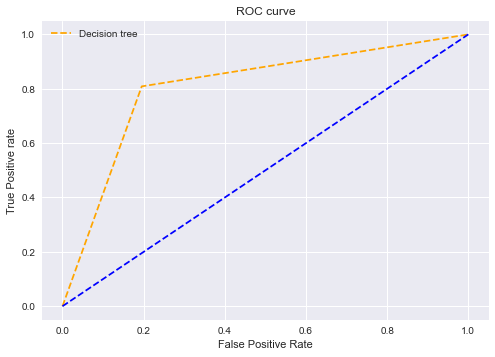

In [17]:
model2 =DecisionTreeClassifier(max_depth=15)
model2.fit(x_train, y_train)
pred_prob1 = model2.predict_proba(x_test)
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
#fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
#auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print(auc_score1)

import matplotlib.pyplot as plt
plt.style.use('seaborn')
matplotlib.pyplot.axes.set_facecolor(color=None)
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Decision tree')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
train_start_time = datetime.now()
print('training the model..')
model1 = RandomForestClassifier(n_estimators=60)
model1.fit(x_train, y_train)
TRAIN_ACCURACY= accuracy_score(y_train, model1.predict(x_train))
print('Done')
train_end_time = datetime.now()
TIMING =  train_end_time - train_start_time
print('training_time(HH:MM:SS.ms) - {}\n\n'.format(TIMING))
#predicting the traget variable using testing variables
test_start_time = datetime.now()
# predict test data
print('Predicting test data')
y_pred1 = model1.predict(x_test)
TESTING_ACCURACY = accuracy_score(y_test, y_pred1)
test_end_time = datetime.now()
TEST_TIMING = test_end_time - test_start_time
print('testing time(HH:MM:SS:ms) - {}\n\n'.format(TEST_TIMING))
#Results
print("Random forest Results")
print("Random forest Training Accuracy: ",TRAIN_ACCURACY*100,"%")
print("Random forest Testing Accuracy: ",TESTING_ACCURACY*100,"%")

print('\n')
print('| Confusion Matrix |')
print('\n')
print(confusion_matrix(y_test, y_pred1))

print('\n')
print(' Classifiction Report ')
print('\n')
classification_report = metrics.classification_report(y_test, y_pred1)
print(classification_report)

training the model..
Done
training_time(HH:MM:SS.ms) - 0:00:00.494718


Predicting test data
testing time(HH:MM:SS:ms) - 0:00:00.009966


Random forest Results
Random forest Training Accuracy:  100.0 %
Random forest Testing Accuracy:  87.39946380697052 %


| Confusion Matrix |


[[154  15]
 [ 32 172]]


 Classifiction Report 


              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87       169
         1.0       0.92      0.84      0.88       204

    accuracy                           0.87       373
   macro avg       0.87      0.88      0.87       373
weighted avg       0.88      0.87      0.87       373



0.9377247940596357


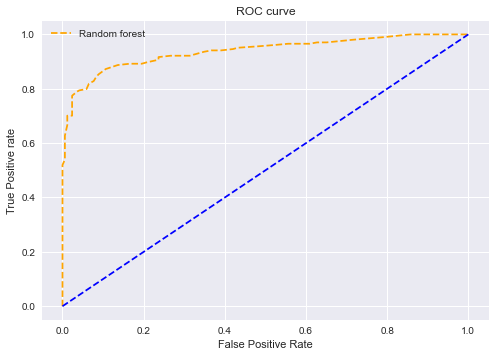

In [19]:
model2 =RandomForestClassifier(n_estimators=60)
model2.fit(x_train, y_train)
pred_prob1 = model2.predict_proba(x_test)
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
#fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
#auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print(auc_score1)

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random forest')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
model6 = KNeighborsClassifier(n_neighbors = 5)
model6.fit(x_train, y_train)
y_pred6 = model6.predict(x_test)
print("KNN")
print("KnnAccuracy: ",accuracy_score(y_test, y_pred6)*100,"%")
print("Train Accuracy:",model6.score(x_train, y_train))
print("Test Accuracy:",model6.score(x_test, y_test))
print("Precision Score: ",metrics.precision_score(y_test, y_pred6, average='weighted'))
print("Recall Score: ",metrics.recall_score(y_test, y_pred6, average='weighted'))
print("F1 Score: ",metrics.f1_score(y_test, y_pred6, average='weighted'))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred6))


KNN
KnnAccuracy:  73.35766423357664 %
Train Accuracy: 0.8135283363802559
Test Accuracy: 0.7335766423357665
Precision Score:  0.7360059559454254
Recall Score:  0.7335766423357665
F1 Score:  0.7311776019321603
Confusion Matrix: 
[[118  27]
 [ 46  83]]


0.6079881656804734


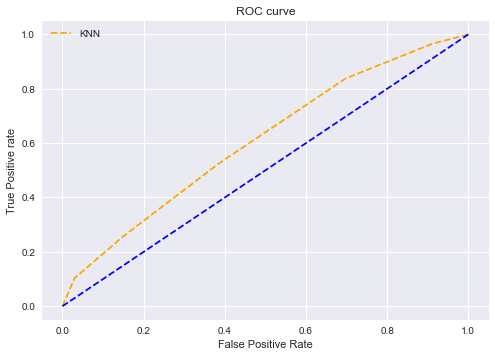

In [21]:
model2 = KNeighborsClassifier(n_neighbors = 5)
model2.fit(x_train, y_train)
pred_prob1 = model2.predict_proba(x_test)
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
#fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
#auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print(auc_score1)

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='KNN')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

### AdaBoost

In [24]:
from sklearn.ensemble import AdaBoostClassifier

In [44]:
train_start_time = datetime.now()
print('training the model..')
model1 = AdaBoostClassifier(random_state = 96)
model1.fit(x_train, y_train)
TRAIN_ACCURACY= accuracy_score(y_train, model1.predict(x_train))
print('Done')
train_end_time = datetime.now()
TIMING =  train_end_time - train_start_time
print('training_time(HH:MM:SS.ms) - {}\n\n'.format(TIMING))
#predicting the traget variable using testing variables
test_start_time = datetime.now()
# predict test data
print('Predicting test data')
y_pred1 = model1.predict(x_test)
TESTING_ACCURACY = accuracy_score(y_test, y_pred1)
test_end_time = datetime.now()
TEST_TIMING = test_end_time - test_start_time
print('testing time(HH:MM:SS:ms) - {}\n\n'.format(TEST_TIMING))
#Results
print("AdaBoost Results")
print("AdaBoost Training Accuracy: ",TRAIN_ACCURACY*100,"%")
print("AdaBoost Testing Accuracy: ",TESTING_ACCURACY*100,"%")

print('\n')
print('| Confusion Matrix |')
print('\n')
print(confusion_matrix(y_test, y_pred1))

print('\n')
print(' Classifiction Report ')
print('\n')
classification_report = metrics.classification_report(y_test, y_pred1)
print(classification_report)

training the model..
Done
training_time(HH:MM:SS.ms) - 0:00:00.793878


Predicting test data
testing time(HH:MM:SS:ms) - 0:00:00.013006


AdaBoost Results
AdaBoost Training Accuracy:  89.00067069081153 %
AdaBoost Testing Accuracy:  79.35656836461126 %


| Confusion Matrix |


[[140  29]
 [ 48 156]]


 Classifiction Report 


              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78       169
         1.0       0.84      0.76      0.80       204

    accuracy                           0.79       373
   macro avg       0.79      0.80      0.79       373
weighted avg       0.80      0.79      0.79       373



0.8819613644274279


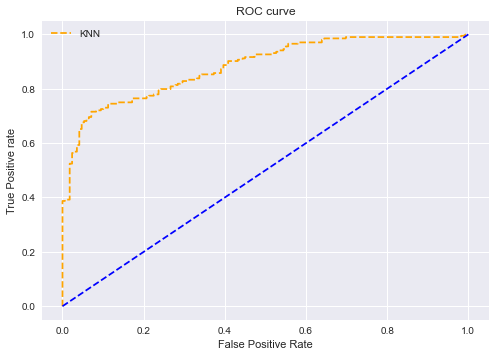

In [35]:
model2 = AdaBoostClassifier(random_state = 96)
model2.fit(x_train, y_train)
pred_prob1 = model2.predict_proba(x_test)
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
#fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
#auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print(auc_score1)

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(markerfacecolor='blue')
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='KNN')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

### XGBoost

In [47]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [48]:
pip install --upgrade xgboost

Requirement already up-to-date: xgboost in c:\users\ceplus\miniconda3\lib\site-packages (1.6.1)
Note: you may need to restart the kernel to use updated packages.


In [26]:
from numpy import loadtxt
from xgboost import XGBClassifier

In [50]:
train_start_time = datetime.now()
print('training the model..')
model1 = XGBClassifier()
model1.fit(x_train, y_train)
TRAIN_ACCURACY= accuracy_score(y_train, model1.predict(x_train))
print('Done')
train_end_time = datetime.now()
TIMING =  train_end_time - train_start_time
print('training_time(HH:MM:SS.ms) - {}\n\n'.format(TIMING))
#predicting the traget variable using testing variables
test_start_time = datetime.now()
# predict test data
print('Predicting test data')
y_pred1 = model1.predict(x_test)
TESTING_ACCURACY = accuracy_score(y_test, y_pred1)
test_end_time = datetime.now()
TEST_TIMING = test_end_time - test_start_time
print('testing time(HH:MM:SS:ms) - {}\n\n'.format(TEST_TIMING))
#Results
print("AdaBoost Results")
print("AdaBoost Training Accuracy: ",TRAIN_ACCURACY*100,"%")
print("AdaBoost Testing Accuracy: ",TESTING_ACCURACY*100,"%")

print('\n')
print('| Confusion Matrix |')
print('\n')
print(confusion_matrix(y_test, y_pred1))

print('\n')
print(' Classifiction Report ')
print('\n')
classification_report = metrics.classification_report(y_test, y_pred1)
print(classification_report)

training the model..
Done
training_time(HH:MM:SS.ms) - 0:00:01.110031


Predicting test data
testing time(HH:MM:SS:ms) - 0:00:00.005985


AdaBoost Results
AdaBoost Training Accuracy:  100.0 %
AdaBoost Testing Accuracy:  89.00804289544236 %


| Confusion Matrix |


[[155  14]
 [ 27 177]]


 Classifiction Report 


              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       169
         1.0       0.93      0.87      0.90       204

    accuracy                           0.89       373
   macro avg       0.89      0.89      0.89       373
weighted avg       0.89      0.89      0.89       373



### Logistic regression

In [28]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [30]:
train_start_time = datetime.now()
print('training the model..')
model1 = LogisticRegression(random_state=0,max_iter=1000)
model1.fit(x_train, y_train)
TRAIN_ACCURACY= accuracy_score(y_train, model1.predict(x_train))
print('Done')
train_end_time = datetime.now()
TIMING =  train_end_time - train_start_time
print('training_time(HH:MM:SS.ms) - {}\n\n'.format(TIMING))
#predicting the traget variable using testing variables
test_start_time = datetime.now()
# predict test data
print('Predicting test data')
y_pred1 = model1.predict(x_test)
TESTING_ACCURACY = accuracy_score(y_test, y_pred1)
test_end_time = datetime.now()
TEST_TIMING = test_end_time - test_start_time
print('testing time(HH:MM:SS:ms) - {}\n\n'.format(TEST_TIMING))
#Results
print("Logistic Regression Results")
print("Logistic Regression Training Accuracy: ",TRAIN_ACCURACY*100,"%")
print("Logistic Regression Testing Accuracy: ",TESTING_ACCURACY*100,"%")

print('\n')
print('| Confusion Matrix |')
print('\n')
print(confusion_matrix(y_test, y_pred1))

print('\n')
print(' Classifiction Report ')
print('\n')
classification_report = metrics.classification_report(y_test, y_pred1)
print(classification_report)

training the model..
Done
training_time(HH:MM:SS.ms) - 0:00:00.219411


Predicting test data
testing time(HH:MM:SS:ms) - 0:00:00.001995


Logistic Regression Results
Logistic Regression Training Accuracy:  71.42857142857143 %
Logistic Regression Testing Accuracy:  72.65415549597856 %


| Confusion Matrix |


[[131  38]
 [ 64 140]]


 Classifiction Report 


              precision    recall  f1-score   support

         0.0       0.67      0.78      0.72       169
         1.0       0.79      0.69      0.73       204

    accuracy                           0.73       373
   macro avg       0.73      0.73      0.73       373
weighted avg       0.73      0.73      0.73       373



0.7851548903585103


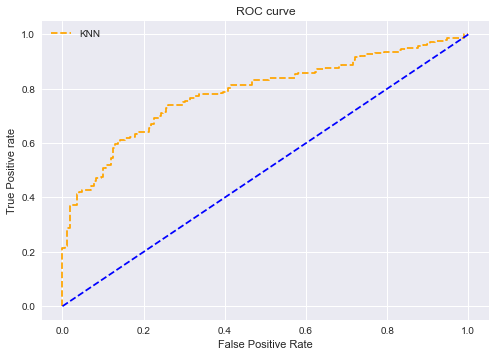

In [29]:
model2 = LogisticRegression(random_state=0,max_iter=1000)
model2.fit(x_train, y_train)
pred_prob1 = model2.predict_proba(x_test)
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
#fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
#auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print(auc_score1)

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='KNN')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()